1) 데이터 준비 (tiff 이미지랑 csv파일)
2) stardist나 cellpose 사용해서 전체 cell들에 대해 segmentation
3) Cell feature들 추출 (by PathOmics)
4) 한 glom 안의 모든 세포들의 feature 집계 (이것도 PathOmics로 가능?)
5) CSV파일에 있는거 바탕으로 M0/M1 매칭
6) 머신러닝 모델 학습
7) 예측 및 해석

1번은 이미 받았으니까 PASS

2) 이미지 전처리 + Stardist 사용하여 cell segmentation

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


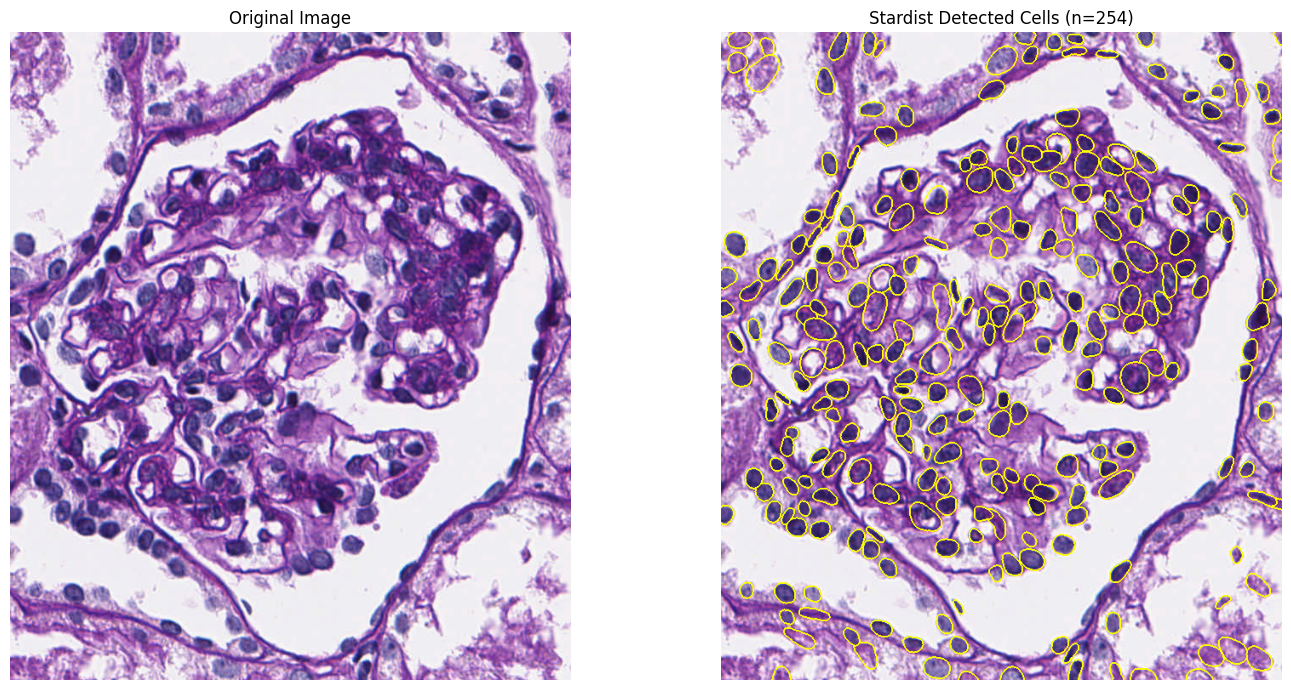

In [2]:
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2

# StarDist 모델 로딩
model = StarDist2D.from_pretrained('2D_versatile_he')

# CLAHE 전처리 함수
def color_normalize(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
    cl = clahe.apply(l)
    normalized = cv2.merge((cl, a, b))
    normalized = cv2.cvtColor(normalized, cv2.COLOR_LAB2RGB)
    return normalized

# 이미지 불러오기 (예시 경로 바꾸기)
image_path = r"C:\glom ML task\glom_patch\11_01_0001_PAS\11_01_0001_PAS_g00.tiff"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 전처리 + 정규화
normalized = color_normalize(image)
normalized = normalize(normalized, 1, 99.8)

# StarDist 예측
labels, details = model.predict_instances(normalized, prob_thresh=0.4, nms_thresh=0.3)

# 경계선 시각화
from skimage.segmentation import find_boundaries
boundaries = find_boundaries(labels, mode='thick')
image_with_boundaries = image.copy()
image_with_boundaries[boundaries] = [255, 255, 0]

# 결과 시각화
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image_with_boundaries)
plt.title(f"Stardist Detected Cells (n={np.max(labels)})")
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
len(details['coord'])

254

In [13]:
labels[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114,
       114, 114, 114, 114, 114, 114, 114,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  24,  24,  24,  24,  24,
        24,  24,  24,  24,  24,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  74,  74,  74,  74,  74,  74,  74,  74,  74,   0,   

가지고 있는 모든 이미지들에 대해 일괄적으로 전처리 + stardist 사용하여 cell segmentation 진행
파일경로와 라벨, 분할된 세포 숫자는 stardist_segmentation_light.pkl에 일괄적으로 저장

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from tqdm import tqdm

# StarDist 모델 로딩
model = StarDist2D.from_pretrained('2D_versatile_he')

# CLAHE 전처리 함수
def color_normalize(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
    cl = clahe.apply(l)
    normalized = cv2.merge((cl, a, b))
    normalized = cv2.cvtColor(normalized, cv2.COLOR_LAB2RGB)
    return normalized

# CSV 로드
csv_path = r"C:\glom ML task\binary_labels.csv" 
df = pd.read_csv(csv_path)

# 이미지 루트 경로
base_dir = r"C:\glom ML task\glom_patch"

# 세그멘테이션 마스크 저장 디렉토리
save_dir = r"C:\glom ML task\segmentation_masks_stardist"
os.makedirs(save_dir, exist_ok=True)


# 전체 이미지 처리
for i, row in tqdm(df.iterrows(), total=len(df)):
    rel_path = row["filepath"]
    label = row["label"]
    
    img_path = os.path.join(base_dir, rel_path)
    
    # 이미지 로드
    image = cv2.imread(img_path)
    if image is None:
        print(f"⚠️ 이미지 로드 실패: {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 전처리 + 정규화
    normalized = color_normalize(image)
    normalized = normalize(normalized, 1, 99.8)

    # StarDist 세포 분할
    labels, _ = model.predict_instances(normalized, prob_thresh=0.4, nms_thresh=0.3)

    # 저장 파일명 설정 (.npz)
    fname = os.path.splitext(os.path.basename(rel_path))[0]
    save_path = os.path.join(save_dir, f"{fname}.npz")

    # 마스크 저장
    np.savez_compressed(save_path, mask=labels)


print("✅ segmentation mask를 npz 형식으로 저장 완료!")

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


100%|██████████| 1480/1480 [20:15<00:00,  1.22it/s]

✅ segmentation mask를 npz 형식으로 저장 완료!


In [5]:
import os
import shutil
from tqdm import tqdm

# 1️⃣ 정리 대상 폴더 (npz 저장된 위치)
src_dir = r"C:\glom ML task\segmentation_masks_stardist"

# 2️⃣ 대상 파일 목록
files = [f for f in os.listdir(src_dir) if f.endswith(".npz")]

# 3️⃣ 각 파일을 폴더별로 이동
for f in tqdm(files):
    # 예: 11_01_0001_PAS_g00.npz → 11_01_0001_PAS
    prefix = f.split("_g")[0]  # '11_01_0001_PAS'
    dst_folder = os.path.join(src_dir, prefix)
    os.makedirs(dst_folder, exist_ok=True)

    # 파일 이동
    src_path = os.path.join(src_dir, f)
    dst_path = os.path.join(dst_folder, f)
    shutil.move(src_path, dst_path)

print("✅ npz 파일 정리 완료!")

100%|██████████| 1480/1480 [00:02<00:00, 555.64it/s]

✅ npz 파일 정리 완료!


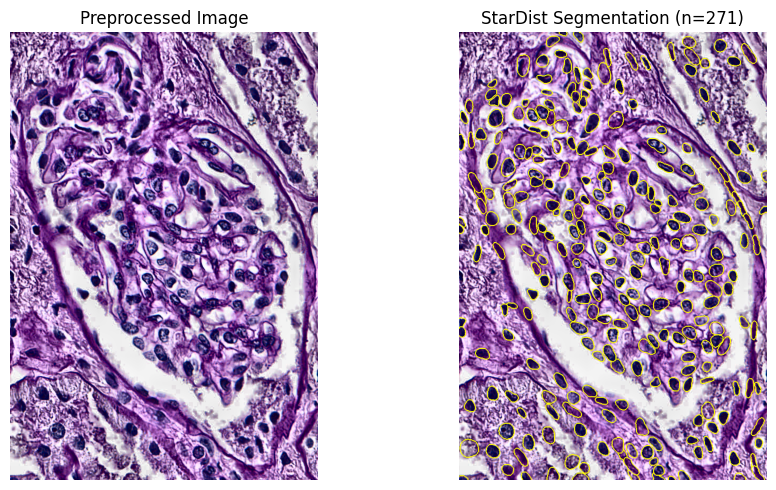

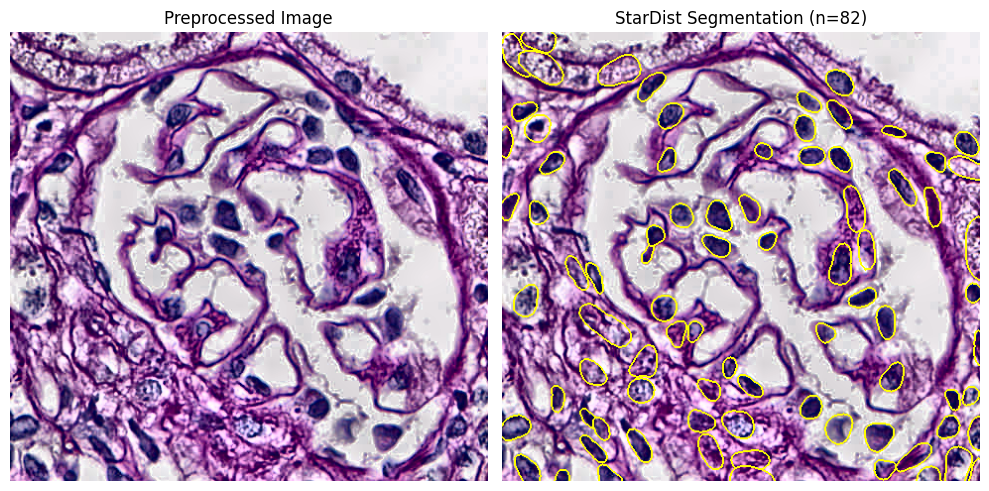

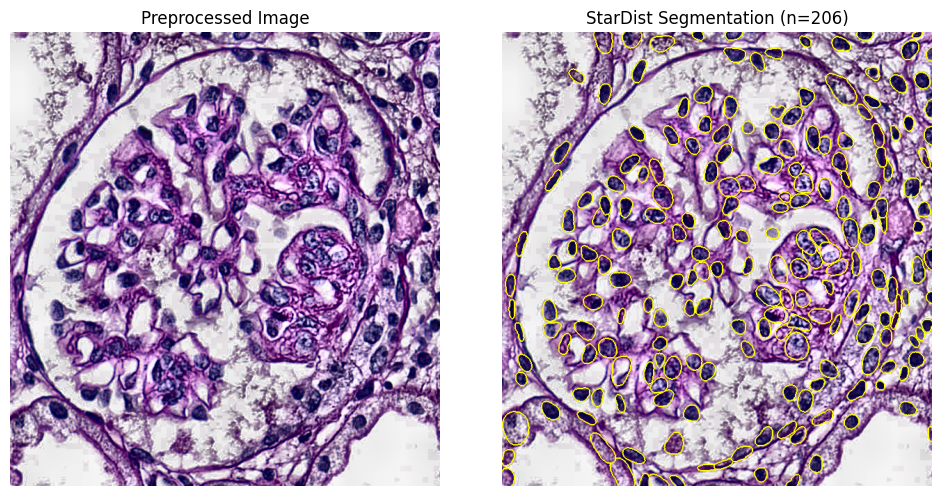

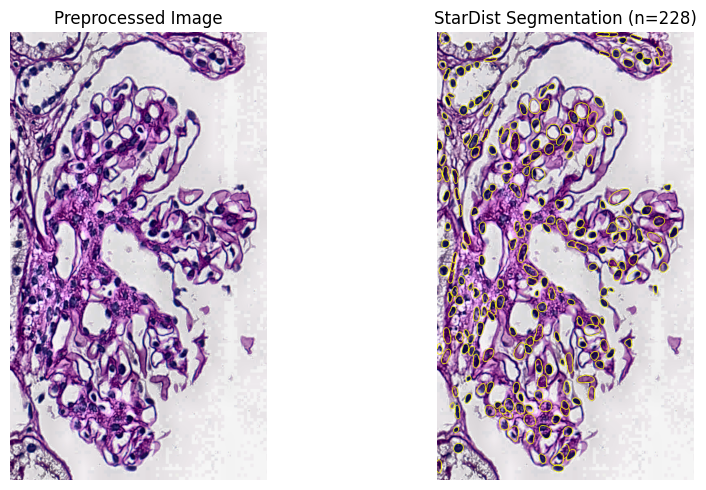

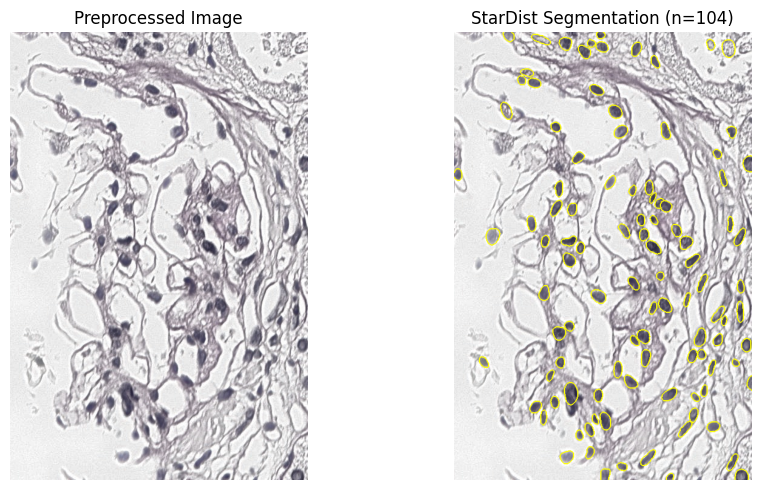

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.segmentation import find_boundaries

# 기본 경로
base_img_dir = r"C:\glom ML task\glom_patch"
mask_dir = r"C:\glom ML task\segmentation_masks_stardist"
csv_path = r"C:\glom ML task\binary_labels.csv"

# CSV 불러오기
df = pd.read_csv(csv_path)

# CLAHE 함수
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final

# 5장 무작위 선택
sample_df = df.sample(n=5, random_state=42)

# 시각화
for _, row in sample_df.iterrows():
    rel_path = row["filepath"]
    img_path = os.path.join(base_img_dir, rel_path)
    npz_name = os.path.basename(rel_path).replace(".tiff", ".npz")
    subfolder = os.path.dirname(rel_path)
    npz_path = os.path.join(mask_dir, subfolder, npz_name)

    # 이미지 로드
    image = cv2.imread(img_path)
    if image is None:
        print(f"❌ 이미지 로드 실패: {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = apply_clahe(image)

    # 마스크 로드
    if not os.path.exists(npz_path):
        print(f"❌ 마스크 없음: {npz_path}")
        continue
    data = np.load(npz_path)
    masks = data["mask"]  # StarDist는 "mask" 키 사용

    # 경계
    boundaries = find_boundaries(masks)
    overlay = image.copy()
    overlay[boundaries] = [255, 255, 0]  # 노란색

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Preprocessed Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title(f"StarDist Segmentation (n={masks.max()})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

3) Cell feature들 추출

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from skimage.measure import regionprops_table
from skimage.segmentation import find_boundaries
from scipy.spatial import distance_matrix

# 1️⃣ 경로 설정
image_path = r"C:\glom ML task\glom_patch\11_01_0001_PAS\11_01_0001_PAS_g00.tiff"

# 2️⃣ 모델 로딩
model = StarDist2D.from_pretrained("2D_versatile_he")

# 3️⃣ 전처리 함수
def color_normalize(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
    cl = clahe.apply(l)
    normalized = cv2.merge((cl, a, b))
    normalized = cv2.cvtColor(normalized, cv2.COLOR_LAB2RGB)
    return normalized

# 4️⃣ 이미지 로드 및 전처리
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_norm = color_normalize(img)
img_norm = normalize(img_norm, 1, 99.8)

# 5️⃣ Stardist segmentation
labels, _ = model.predict_instances(img_norm)

# 6️⃣ regionprops 기반 세포 feature 추출
df_cell = pd.DataFrame(regionprops_table(
    labels,
    properties=["area", "eccentricity", "solidity", "orientation", "centroid"]
))

# 7️⃣ 세포 간 거리 계산 (centroid 기반)
coords = df_cell[["centroid-0", "centroid-1"]].values  # (y, x)
if len(coords) > 1:
    dists = distance_matrix(coords, coords)
    min_dists = np.sort(dists, axis=1)[:, 1]  # 자기 자신 제외한 최소 거리
    mean_min_dist = np.mean(min_dists)
else:
    mean_min_dist = 0  # 세포 1개 이하일 경우

# 8️⃣ 밀도 계산 (전체 이미지 기준)
h, w = img.shape[:2]
cell_density = len(df_cell) / (h * w)

# 9️⃣ 요약 feature 딕셔너리로 정리
summary = {
    "mean_area": df_cell["area"].mean(),
    "std_area": df_cell["area"].std(),
    "mean_solidity": df_cell["solidity"].mean(),
    "mean_eccentricity": df_cell["eccentricity"].mean(),
    "cell_count": len(df_cell),
    "mean_min_dist": mean_min_dist,
    "density": cell_density
}

# 🔟 출력
print("▶️ Glom-level feature summary:")
for k, v in summary.items():
    if k == "density":
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v:.3f}")


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
▶️ Glom-level feature summary:
mean_area: 383.216
std_area: 148.092
mean_solidity: 0.959
mean_eccentricity: 0.687
cell_count: 148.000
mean_min_dist: 33.488
density: 0.000295


전체 이미지에 대해 3번 적용

In [9]:
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from skimage.measure import regionprops_table
from scipy.spatial import distance_matrix

# 🔹 경로 설정
csv_path = r"C:\glom ML task\binary_labels.csv"
df_meta = pd.read_csv(csv_path)
base_dir_img = r"C:\glom ML task\glom_patch"
base_dir_npz = r"C:\glom ML task\segmentation_masks_stardist"
save_path_csv = r"C:\glom ML task\ml_features_stardist.csv"

results = []

for i, row in tqdm(df_meta.iterrows(), total=len(df_meta)):
    rel_path = row["filepath"]
    label = row["label"]
    
    # 원본 이미지 경로
    img_path = os.path.join(base_dir_img, rel_path)
    if not os.path.exists(img_path):
        print(f"❌ 이미지 없음: {img_path}")
        continue

    # npz 경로 (확장자 변경 및 폴더 처리)
    name = os.path.basename(rel_path).replace(".tiff", ".npz")
    folder = os.path.basename(os.path.dirname(rel_path))
    npz_path = os.path.join(base_dir_npz, folder, name)
    
    if not os.path.exists(npz_path):
        print(f"❌ 마스크 없음: {npz_path}")
        continue

    # 이미지 크기 로드
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # 마스크 로딩
    data = np.load(npz_path)
    masks = data["mask"]

    # regionprops feature 계산
    props = regionprops_table(masks, properties=["area", "eccentricity", "solidity", "centroid"])
    df_cell = pd.DataFrame(props)

    # 거리 계산
    coords = df_cell[["centroid-0", "centroid-1"]].values
    if len(coords) > 1:
        dists = distance_matrix(coords, coords)
        min_dists = np.sort(dists, axis=1)[:, 1]
        mean_min_dist = np.mean(min_dists)
    else:
        mean_min_dist = 0

    # 밀도 계산
    density = len(df_cell) / (h * w)

    # 결과 저장
    results.append({
        "filepath": rel_path,
        "label": label,
        "cell_count": len(df_cell),
        "mean_area": df_cell["area"].mean(),
        "std_area": df_cell["area"].std(),
        "mean_solidity": df_cell["solidity"].mean(),
        "mean_eccentricity": df_cell["eccentricity"].mean(),
        "mean_min_dist": mean_min_dist,
        "density": density
    })

# 최종 저장
df_result = pd.DataFrame(results)
df_result.to_csv(save_path_csv, index=False)
print("✅ Cellpose 기반 feature CSV 저장 완료:", save_path_csv)

100%|██████████| 1480/1480 [09:43<00:00,  2.53it/s]

✅ Cellpose 기반 feature CSV 저장 완료: C:\glom ML task\ml_features_stardist.csv


In [10]:
import pandas as pd

# 저장된 경로
csv_path = r"C:\glom ML task\ml_features_stardist.csv"

# 불러오기
df = pd.read_csv(csv_path)

# 상위 5개 행만 확인
print(df.head())

                                 filepath  label  cell_count   mean_area  \
0  11_01_0001_PAS/11_01_0001_PAS_g00.tiff      1         254  372.555118   
1  11_01_0001_PAS/11_01_0001_PAS_g01.tiff      1         244  420.413934   
2  11_01_0001_PAS/11_01_0001_PAS_g02.tiff      0         177  409.672316   
3  11_01_0001_PAS/11_01_0001_PAS_g03.tiff      1         267  389.138577   
4  11_01_0001_PAS/11_01_0001_PAS_g06.tiff      1         323  336.452012   

     std_area  mean_solidity  mean_eccentricity  mean_min_dist   density  
0  173.344669       0.949381           0.725471      26.811963  0.000506  
1  233.055577       0.950367           0.728525      26.749123  0.000597  
2  184.169651       0.947663           0.731111      26.955318  0.000506  
3  149.229725       0.953486           0.721228      26.501916  0.000531  
4  141.183617       0.951135           0.732205      24.729976  0.000585  


머신러닝 모델 학습 (Random Forest)

In [1]:
import os
import pandas as pd

# 1. 데이터 불러오기
df_feat = pd.read_csv(r"C:\glom ML task\ml_features_stardist.csv")
df_meta = pd.read_csv(r"C:\glom ML task\241121_updated_m0m1e1.csv")

# 2. filepath 정규화 (뒤 경로만 추출)
# ../../data/patch/11_01_0001_PAS/11_01_0001_PAS_g00.tiff → 11_01_0001_PAS/11_01_0001_PAS_g00.tiff
df_meta["filepath_norm"] = df_meta["filepath"].apply(lambda x: os.path.normpath(x).split("patch" + os.sep)[-1])

# 3. df_feat 경로도 정리 (Windows 슬래시 → 정규화)
df_feat["filepath_norm"] = df_feat["filepath"].apply(lambda x: os.path.normpath(x))

# 4. 병합 수행 (filepath_norm 기준)
df = pd.merge(df_feat, df_meta[["filepath_norm", "tvt"]], on="filepath_norm", how="inner")

# 확인
print("✅ 병합 결과 row 수:", len(df))
print("📊 tvt 분포:")
print(df["tvt"].value_counts())

✅ 병합 결과 row 수: 1480
📊 tvt 분포:
tvt
train    991
valid    249
test     240
Name: count, dtype: int64



✅ [Validation] Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       148
           1       0.67      0.36      0.46       101

    accuracy                           0.67       249
   macro avg       0.67      0.62      0.61       249
weighted avg       0.67      0.67      0.64       249



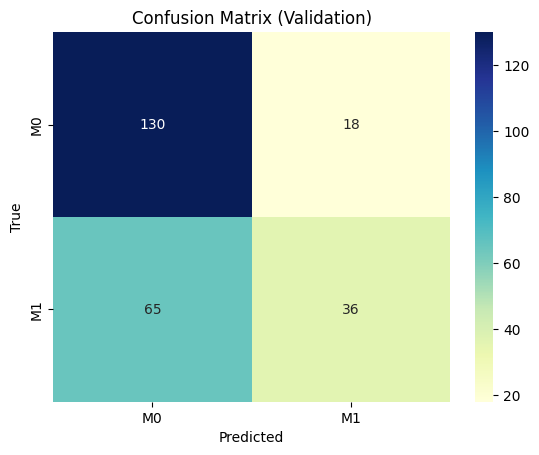

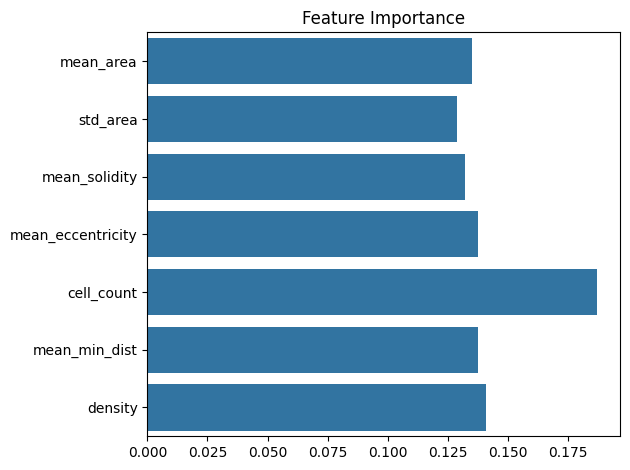

NameError: name 'model' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ✅ feature 컬럼
feature_cols = [
    "mean_area", "std_area", "mean_solidity", "mean_eccentricity",
    "cell_count", "mean_min_dist", "density"
]

# ✅ 데이터 분할
X_train = df[df["tvt"] == "train"][feature_cols]
y_train = df[df["tvt"] == "train"]["label"]

X_valid = df[df["tvt"] == "valid"][feature_cols]
y_valid = df[df["tvt"] == "valid"]["label"]

X_test = df[df["tvt"] == "test"][feature_cols]
y_test = df[df["tvt"] == "test"]["label"]

# ✅ 모델 학습
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced",random_state=42)
rf.fit(X_train, y_train)

# ✅ Validation 평가
y_pred_valid = rf.predict(X_valid)
print(f"\n✅ [Validation] Accuracy: {accuracy_score(y_valid, y_pred_valid):.4f}")
print(classification_report(y_valid, y_pred_valid))

# ✅ 혼동 행렬 (valid 기준)
cm = confusion_matrix(y_valid, y_pred_valid)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=["M0", "M1"], yticklabels=["M0", "M1"])
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ Feature importance
importances = rf.feature_importances_
sns.barplot(x=importances, y=feature_cols)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

# ✅ Test 평가 (최종 결과)
y_pred = model.predict(X_test)

# 📊 성능 리포트 출력
print("\n Classification Report:")
print(f"\n [Test] Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, digits=2))

cm_test = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_test, annot= True, fmt="d", cmap="Blues", xticklabels=["Pred M0", "Pred M1"], yticklabels=["True M0", "True M1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 예측 확률값 (M1 클래스에 대한 확률)
y_proba_test = rf.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

# 시각화
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"🧪 [Test] ROC AUC: {roc_auc:.4f}")

y_proba_valid = rf.predict_proba(X_valid)[:, 1]
fpr_v, tpr_v, _ = roc_curve(y_valid, y_proba_valid)
roc_auc_v = auc(fpr_v, tpr_v)

plt.plot(fpr_v, tpr_v, label=f"Validation AUC = {roc_auc_v:.4f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\mskim\anaconda3\envs\stardist_py38\lib\site-packages\xgboost\core.py:158: UserWarning: [19:20:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ [Validation] Accuracy: 0.6908
              precision    recall  f1-score   support

           0       0.70      0.84      0.76       148
           1       0.67      0.48      0.55       101

    accuracy                           0.69       249
   macro avg       0.68      0.66      0.66       249
weighted avg       0.69      0.69      0.68       249



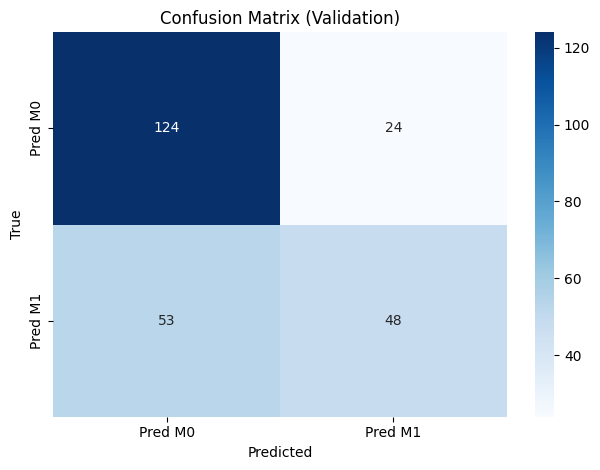

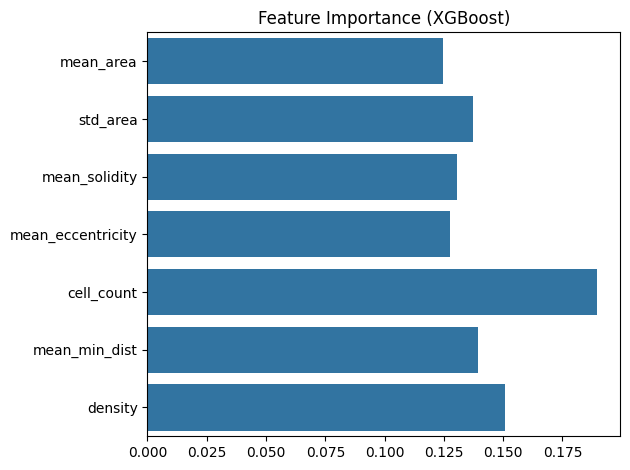


 [Test] Accuracy: 0.6458
              precision    recall  f1-score   support

           0       0.68      0.76      0.72       143
           1       0.57      0.47      0.52        97

    accuracy                           0.65       240
   macro avg       0.63      0.62      0.62       240
weighted avg       0.64      0.65      0.64       240



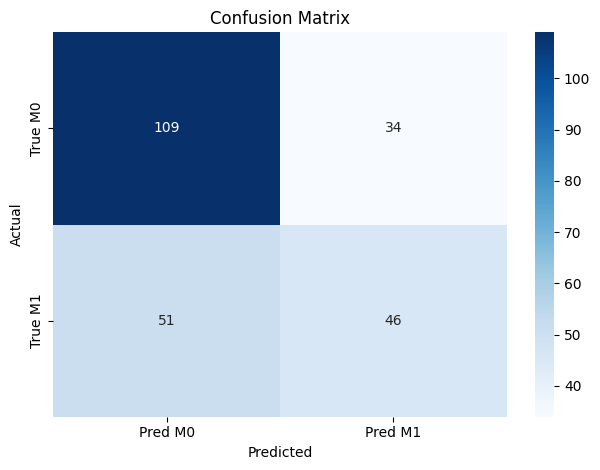

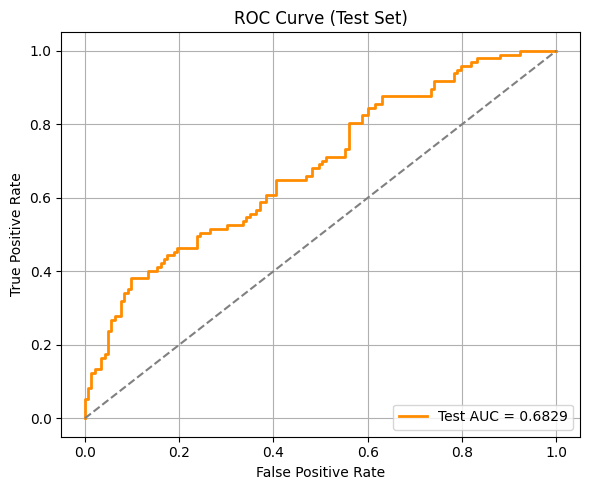

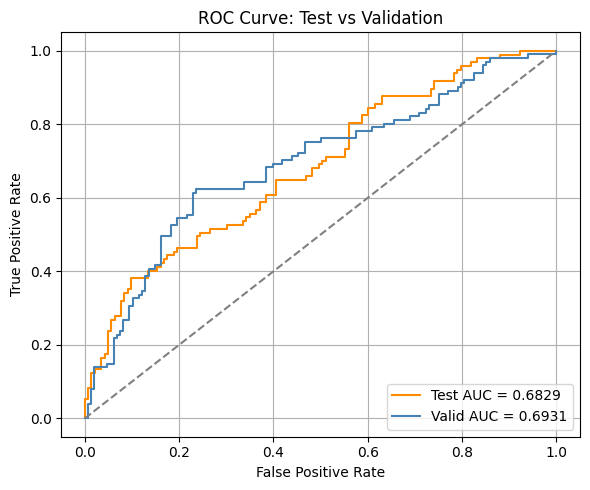

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ feature 컬럼
feature_cols = [
    "mean_area", "std_area", "mean_solidity", "mean_eccentricity",
    "cell_count", "mean_min_dist", "density"
]

# ✅ 데이터 분할
X_train = df[df["tvt"] == "train"][feature_cols]
y_train = df[df["tvt"] == "train"]["label"]

X_valid = df[df["tvt"] == "valid"][feature_cols]
y_valid = df[df["tvt"] == "valid"]["label"]

X_test = df[df["tvt"] == "test"][feature_cols]
y_test = df[df["tvt"] == "test"]["label"]

# ✅ XGBoost 모델 학습
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# ✅ Validation 평가
y_pred_valid = xgb.predict(X_valid)
print(f"\n✅ [Validation] Accuracy: {accuracy_score(y_valid, y_pred_valid):.4f}")
print(classification_report(y_valid, y_pred_valid))

# ✅ 혼동 행렬 (Validation)
cm_val = confusion_matrix(y_valid, y_pred_valid)
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred M0", "Pred M1"], yticklabels=["Pred M0", "Pred M1"])
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ✅ Feature importance
importances = xgb.feature_importances_
sns.barplot(x=importances, y=feature_cols)
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

# ✅ Test 평가
y_pred_test = xgb.predict(X_test)
print(f"\n [Test] Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test))

cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred M0", "Pred M1"], yticklabels=["True M0", "True M1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ✅ ROC Curve (Test)
y_proba_test = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"Test AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Validation ROC Curve
y_proba_valid = xgb.predict_proba(X_valid)[:, 1]
fpr_v, tpr_v, _ = roc_curve(y_valid, y_proba_valid)
roc_auc_v = auc(fpr_v, tpr_v)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Test AUC = {roc_auc:.4f}", color="darkorange")
plt.plot(fpr_v, tpr_v, label=f"Valid AUC = {roc_auc_v:.4f}", color="steelblue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Test vs Validation")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

SHAP (SHapley Additive exPlanations) 기반 해석

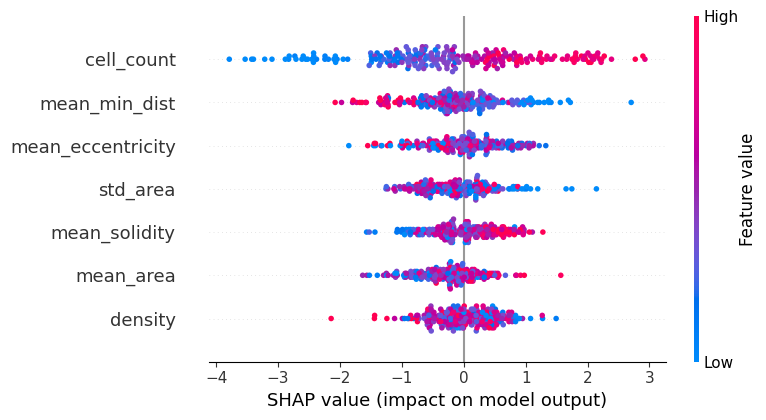

In [26]:
import shap

# SHAP explainer 생성
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

# Force Plot (예시: 첫 번째 테스트 샘플에 대한 해석)
force_html = shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib=False)

# HTML로 저장
shap.save_html("shap_force_plot.html", force_html)
shap.save_html(r"C:\glom ML task\stardist_shap_force_xg_plot.html", force_html)


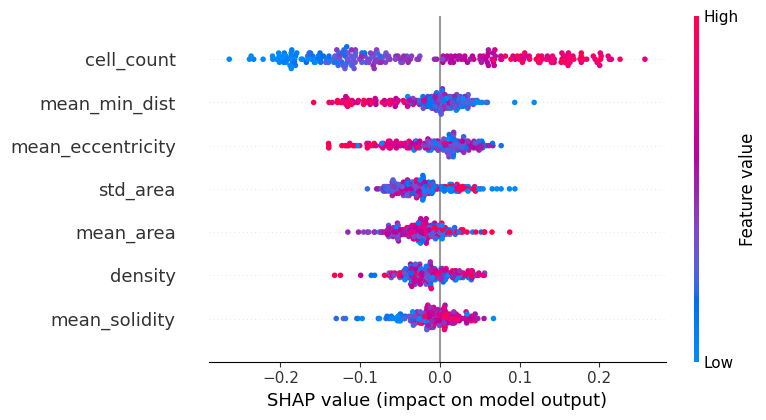

In [27]:
import shap

# SHAP explainer 생성 (RandomForest 모델 기반)
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)

# Summary Plot (Test Set 기준)
shap.summary_plot(shap_values_rf[1], X_test, feature_names=feature_cols)

# Force Plot (테스트 셋 중 첫 번째 샘플)
force_rf = shap.force_plot(
    explainer_rf.expected_value[1],
    shap_values_rf[1][0],
    X_test.iloc[0],
    matplotlib=False
)

# 저장: 웹에서 열 수 있는 HTML 파일
shap.save_html("shap_force_rf.html", force_rf)
shap.save_html(r"C:\glom ML task\stardist_shap_force_rf_plot.html", force_rf)

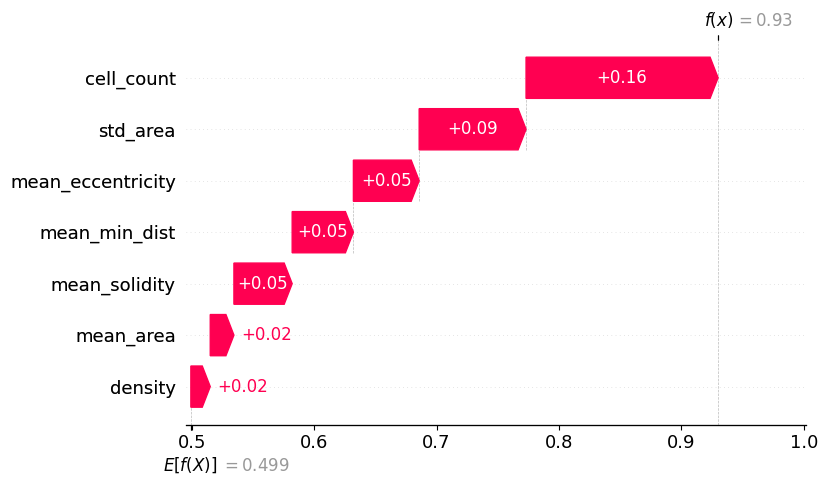

In [20]:
import shap

# 1. SHAP Explainer 객체 생성 (RandomForest 기반)
explainer_rf = shap.TreeExplainer(rf)

# 2. SHAP 값 계산 (클래스별로 반환됨)
shap_values_rf = explainer_rf.shap_values(X_test)

# 3. 시각화 (Waterfall plot로 개별 예측 해석)
shap.plots._waterfall.waterfall_legacy(
    explainer_rf.expected_value[1],  # M1 클래스의 기준값
    shap_values_rf[1][0],            # 첫 번째 샘플에 대한 SHAP 값
    feature_names=feature_cols
)


여기서부터는 8주차 주간발표 목적으로 만들어졌음

In [ ]:
#모든 feature에 대한 단변량 분석#
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import os

# -------------------------------------
# 1. 데이터 로드
# -------------------------------------
csv_path = "C:/glom ML task/ml_features_stardist.csv"  # 필요에 따라 경로 수정
df = pd.read_csv(csv_path)

# -------------------------------------
# 2. 분석 준비
# -------------------------------------
# 분석에 사용할 feature 목록 (label과 filepath 제외)
feature_cols = df.columns.drop(['filepath', 'label'])

# 결과 저장용 리스트 및 폴더 생성
results = []
output_dir = "univariate_analysis_results"
os.makedirs(output_dir, exist_ok=True)

# -------------------------------------
# 3. 단변량 분석 루프
# -------------------------------------
sns.set(style="whitegrid")

for feature in feature_cols:
    group_m0 = df[df['label'] == 0][feature]
    group_m1 = df[df['label'] == 1][feature]
    
    # t-test
    t_stat, p_value = ttest_ind(group_m0, group_m1, equal_var=False)

    # boxplot 저장
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="label", y=feature, data=df)
    plt.title(f"{feature} (p={p_value:.4f})")
    plt.xlabel("Label (0 = M0, 1 = M1)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{feature}_boxplot.png")
    plt.close()

    # 결과 저장
    results.append({
        "feature": feature,
        "mean_M0": group_m0.mean(),
        "mean_M1": group_m1.mean(),
        "p_value": p_value
    })

# -------------------------------------
# 4. 결과 저장
# -------------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv(f"{output_dir}/univariate_ttest_results.csv", index=False)

print("✅ 단변량 분석 완료! 결과는 다음 경로에 저장되었습니다:")
print(f"📁 {output_dir}/univariate_ttest_results.csv")

✅ 단변량 분석 완료! 결과는 다음 경로에 저장되었습니다:
📁 univariate_analysis_results/univariate_ttest_results.csv


In [ ]:
#모든 feature에 대한 다변량 분석#
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import os

# -------------------------------------
# 1. 데이터 로드
# -------------------------------------
csv_path = "C:/glom ML task/ml_features_stardist.csv"  # 필요에 따라 경로 수정
df = pd.read_csv(csv_path)

# -------------------------------------
# 2. 분석 준비
# -------------------------------------
feature_cols = df.columns.drop(['filepath', 'label'])
results = []
output_dir = "univariate_analysis_results"
os.makedirs(output_dir, exist_ok=True)

sns.set(style="whitegrid")

# -------------------------------------
# 3. 단변량 분석 루프
# -------------------------------------
for feature in feature_cols:
    group_m0 = df[df['label'] == 0][feature]
    group_m1 = df[df['label'] == 1][feature]
    
    # t-test
    t_stat, p_value = ttest_ind(group_m0, group_m1, equal_var=False)

    # boxplot 저장
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="label", y=feature, data=df)
    plt.title(f"{feature} (p={p_value:.4f})")
    plt.xlabel("Label (0 = M0, 1 = M1)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{feature}_boxplot.png")
    plt.close()

    # 결과 저장
    results.append({
        "feature": feature,
        "mean_M0": group_m0.mean(),
        "mean_M1": group_m1.mean(),
        "p_value": p_value
    })

# -------------------------------------
# 4. 결과 저장
# -------------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv(f"{output_dir}/univariate_ttest_results.csv", index=False)

# 유의미한 feature만 필터링 (p < 0.05)
significant_df = results_df[results_df["p_value"] < 0.05]
significant_df.to_csv(f"{output_dir}/significant_features_p_under_0.05.csv", index=False)

# 콘솔 출력
print("✅ 단변량 분석 완료!")
print(f"📁 전체 결과: {output_dir}/univariate_ttest_results.csv")
print(f"⭐ 유의미한 feature (p < 0.05): {output_dir}/significant_features_p_under_0.05.csv")

✅ 단변량 분석 완료!
📁 전체 결과: univariate_analysis_results/univariate_ttest_results.csv
⭐ 유의미한 feature (p < 0.05): univariate_analysis_results/significant_features_p_under_0.05.csv


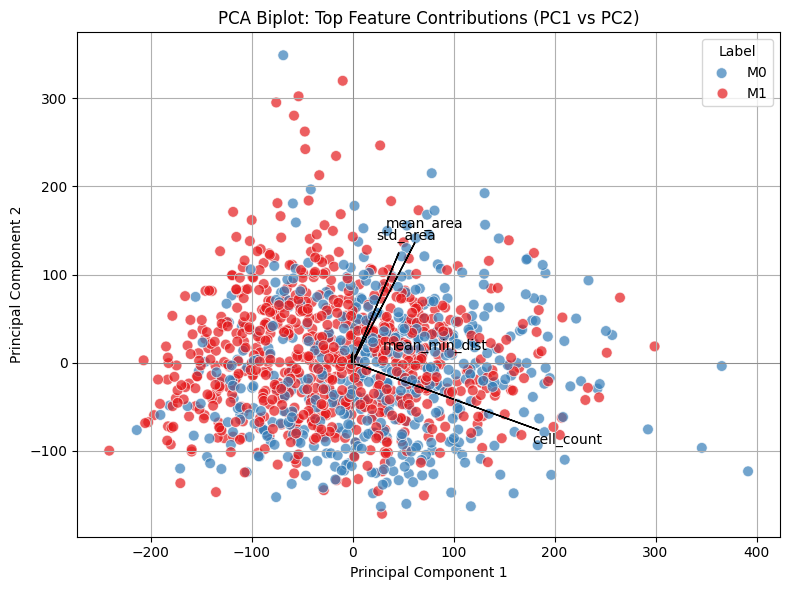

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# -------------------------------------
# 1. PCA 수행 (2D로 축소)
# -------------------------------------
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# 결과를 DataFrame으로 정리
df_pca = pd.DataFrame(X_train_pca, columns=["PC1", "PC2"])
df_pca["label"] = y_train.values  # M0/M1 라벨 추가

# -------------------------------------
# 2. 시각화: PCA biplot
# -------------------------------------
plt.figure(figsize=(8, 6))

# Scatter plot (M0/M1 샘플)
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="label", palette="Set1", s=60, alpha=0.7)

# Feature 화살표 표시
feature_names = X_train.columns
components = pca.components_

# PC1 기준 기여도 큰 상위 4개 feature 선택
top_features = np.argsort(np.abs(components[0]))[::-1][:4]

offset = 10

for i in top_features:
    feature = feature_names[i]
    if feature == "mean_min_dist":
        scale = 500  # 더 길게
    else:
        scale = 200

    x = components[0, i] * scale
    y = components[1, i] * scale

    # 👉 feature 이름에 따라 텍스트 위치 다르게 설정
    if feature == "mean_min_dist":
        plt.arrow(0, 0, x, y,color='black',linewidth=2.5)
        plt.text(x + 30, y + 20, feature, fontsize=10, ha='left', va='top')  # 위치 조정
    else:
        plt.arrow(0, 0, x, y,color='black',linewidth=1)
        plt.text(x * 1.15, y * 1.15, feature, fontsize=10, ha='center', va='center')


# 기타 설정
plt.title("PCA Biplot: Top Feature Contributions (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.grid(True)
plt.legend(title="Label", labels=["M0", "M1"])
plt.tight_layout()
plt.show()

In [13]:
# PCA 학습이 끝난 상태에서:
components = pca.components_  # shape: (n_components, n_features)
feature_names = X_train.columns

# PC1, PC2에 대한 기여도 정리
pc1_weights = pd.Series(components[0], index=feature_names).sort_values(key=abs, ascending=False)
pc2_weights = pd.Series(components[1], index=feature_names).sort_values(key=abs, ascending=False)

print("PC1에 가장 크게 기여한 feature들:")
print(pc1_weights.round(3).head(10))

print("PC2에 가장 크게 기여한 feature들:")
print(pc2_weights.round(3).head(10))

PC1에 가장 크게 기여한 feature들:
cell_count           0.923
mean_area            0.308
std_area             0.229
mean_min_dist        0.000
mean_eccentricity   -0.000
mean_solidity       -0.000
density              0.000
dtype: float64
PC2에 가장 크게 기여한 feature들:
mean_area            0.682
std_area             0.624
cell_count          -0.382
mean_min_dist        0.015
mean_eccentricity    0.000
mean_solidity        0.000
density             -0.000
dtype: float64


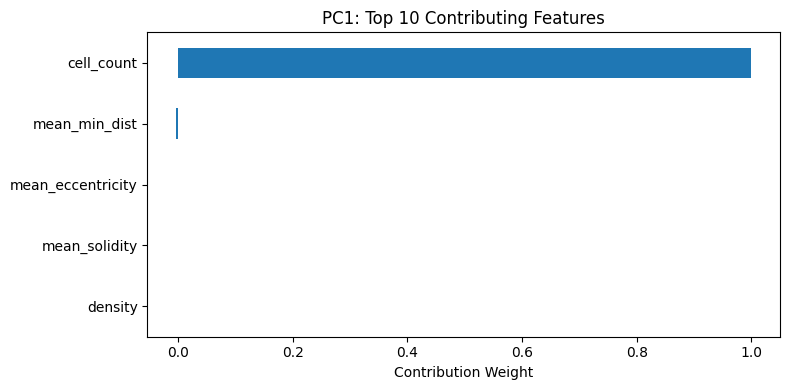

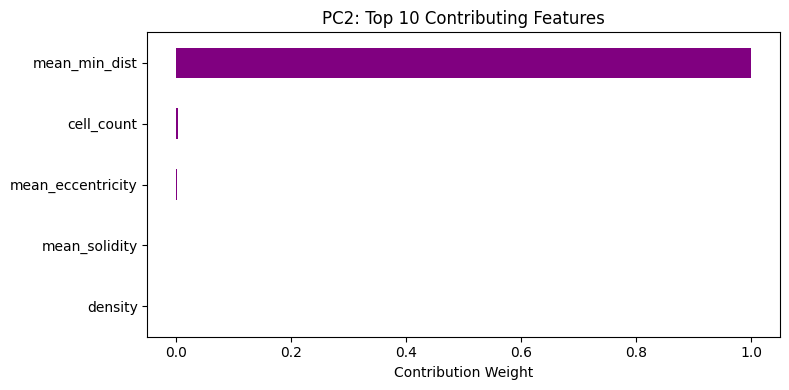

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. PCA 주성분 벡터 불러오기
components = pca.components_   # shape: (n_components, n_features)
feature_names = X_train.columns

# 2. 각 PC별 feature 기여도 계산
pc1_weights = pd.Series(components[0], index=feature_names).sort_values(key=abs, ascending=False)
pc2_weights = pd.Series(components[1], index=feature_names).sort_values(key=abs, ascending=False)

# 3. 상위 10개 feature 시각화
plt.figure(figsize=(8, 4))
pc1_weights.head(10).plot(kind='barh', title="PC1: Top 10 Contributing Features")
plt.gca().invert_yaxis()
plt.xlabel("Contribution Weight")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
pc2_weights.head(10).plot(kind='barh', title="PC2: Top 10 Contributing Features", color="purple")
plt.gca().invert_yaxis()
plt.xlabel("Contribution Weight")
plt.tight_layout()
plt.show()

In [10]:
# ============================================
# Step 1: 유의미한 feature만 추출 (p < 0.05 기준)
# ============================================

import pandas as pd

# 📥 원본 전체 feature 파일 경로
csv_path = "C:/glom ML task/ml_features_stardist.csv"  # 경로 필요 시 수정
df = pd.read_csv(csv_path)

# ✅ 통계적으로 유의미한 feature 목록 (p < 0.05 기준)
significant_features = [
    'cell_count',
    'mean_solidity',
    'mean_eccentricity',
    'mean_min_dist',
    'density'
]

# ✅ label 포함하여 추출 (모델 학습용)
df_selected = df[significant_features + ['label']]

# label과 filepath 모두 포함
df_selected = df[['filepath'] + significant_features + ['label']]
df_selected.to_csv("selected_features_with_filepath.csv", index=False)


# 💾 저장 (원하면)

# 🔍 확인
print("✅ 선택된 feature shape:", df_selected.shape)
print(df_selected.head())

✅ 선택된 feature shape: (1480, 7)
                                 filepath  cell_count  mean_solidity  \
0  11_01_0001_PAS/11_01_0001_PAS_g00.tiff         254       0.949381   
1  11_01_0001_PAS/11_01_0001_PAS_g01.tiff         244       0.950367   
2  11_01_0001_PAS/11_01_0001_PAS_g02.tiff         177       0.947663   
3  11_01_0001_PAS/11_01_0001_PAS_g03.tiff         267       0.953486   
4  11_01_0001_PAS/11_01_0001_PAS_g06.tiff         323       0.951135   

   mean_eccentricity  mean_min_dist   density  label  
0           0.725471      26.811963  0.000506      1  
1           0.728525      26.749123  0.000597      1  
2           0.731111      26.955318  0.000506      0  
3           0.721228      26.501916  0.000531      1  
4           0.732205      24.729976  0.000585      1  


✅ 병합된 데이터 shape: (1480, 9)
📊 TVT 분포:
 tvt
train    991
valid    249
test     240
Name: count, dtype: int64

 Classification Report (p < 0.05):

 [Test] Accuracy: 0.7083
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       143
           1       0.67      0.55      0.60        97

    accuracy                           0.71       240
   macro avg       0.70      0.68      0.69       240
weighted avg       0.70      0.71      0.70       240



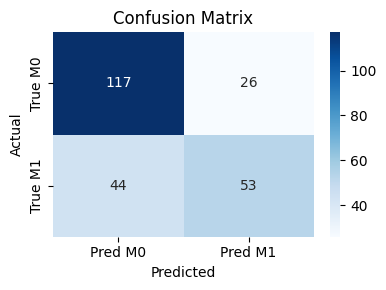

In [17]:
# ============================================
# M0/M1 분류: Random Forest 모델 전체 코드
# (TVT 기반 분할 + 평가 포함)
# ============================================

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------------
# 1. 데이터 로드
# -------------------------------------
# feature와 label 포함된 파일
df_feat = pd.read_csv("C:/glom ML task/selected_features_with_filepath.csv")

# TVT 분할 정보 포함된 파일
df_tvt = pd.read_csv("C:/glom ML task/241121_updated_m0m1e1.csv")

# -------------------------------------
# 2. filepath 기준 병합
# - df_tvt 쪽 filepath에서 끝부분만 추출
# -------------------------------------
df_tvt['filepath_clean'] = df_tvt['filepath'].apply(
    lambda x: x.replace('\\', '/').split('/')[-2] + '/' + x.split('/')[-1]
)

df_merged = pd.merge(
    df_feat,
    df_tvt[['filepath_clean', 'tvt']],
    left_on='filepath',
    right_on='filepath_clean',
    how='inner'
)

print("✅ 병합된 데이터 shape:", df_merged.shape)
print("📊 TVT 분포:\n", df_merged['tvt'].value_counts())

# -------------------------------------
# 3. 학습/테스트 분리
# - 학습: train + valid
# - 테스트: test
# -------------------------------------
trainval_df = df_merged[df_merged['tvt'].isin(['train', 'valid'])]
test_df = df_merged[df_merged['tvt'] == 'test']

X_train = trainval_df.drop(columns=["filepath", "filepath_clean", "label", "tvt"])
y_train = trainval_df["label"]

X_test = test_df.drop(columns=["filepath", "filepath_clean", "label", "tvt"])
y_test = test_df["label"]

# -------------------------------------
# 4. 모델 학습
# -------------------------------------
model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# -------------------------------------
# 5. 예측 및 평가
# -------------------------------------
y_pred = model.predict(X_test)

# 📊 성능 리포트 출력
y_pred_test = model.predict(X_test)
print("\n Classification Report (p < 0.05):")
print(f"\n [Test] Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred, digits=2))


# Confusion matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

p-value < 0.05 가 아닌 feature들까지 합해서 다시 머신러닝 돌려보기

✅ 병합된 데이터 shape: (1480, 11)
📊 TVT 분포:
 tvt
train    991
valid    249
test     240
Name: count, dtype: int64

 Classification Report (All):

 [Test] Accuracy: 0.7000
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       143
           1       0.67      0.55      0.60        97

    accuracy                           0.71       240
   macro avg       0.70      0.68      0.69       240
weighted avg       0.70      0.71      0.70       240



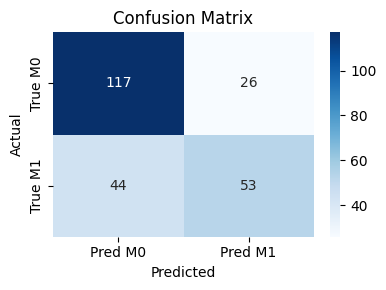

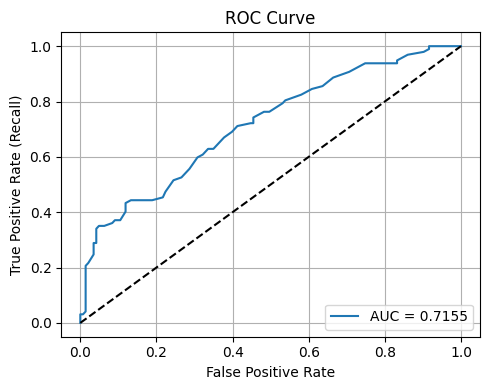

In [35]:
# ============================================
# Random Forest 모델 (전체 feature 포함)
# ============================================

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# -------------------------------------
# 1. 데이터 로드
# -------------------------------------
# 전체 feature + filepath + label 포함된 파일
df_feat = pd.read_csv("C:/glom ML task/all_features_with_filepath_stardist.csv")

# TVT 분할 정보 포함된 파일
df_tvt = pd.read_csv("C:/glom ML task/241121_updated_m0m1e1.csv")

# -------------------------------------
# 2. filepath 기준 병합
# → df_tvt 쪽 경로 정제 후 병합
# -------------------------------------
df_tvt['filepath_clean'] = df_tvt['filepath'].apply(
    lambda x: x.replace('\\', '/').split('/')[-2] + '/' + x.split('/')[-1]
)

df_merged = pd.merge(
    df_feat,
    df_tvt[['filepath_clean', 'tvt']],
    left_on='filepath',
    right_on='filepath_clean',
    how='inner'
)

print("✅ 병합된 데이터 shape:", df_merged.shape)
print("📊 TVT 분포:\n", df_merged['tvt'].value_counts())

# -------------------------------------
# 3. 학습/테스트 분리
# -------------------------------------
trainval_df = df_merged[df_merged['tvt'].isin(['train', 'valid'])]
test_df = df_merged[df_merged['tvt'] == 'test']

drop_cols = ["filepath", "filepath_clean", "label", "tvt"]

X_train = trainval_df.drop(columns=drop_cols)
y_train = trainval_df["label"]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df["label"]

# -------------------------------------
# 4. 모델 학습 (클래스 불균형 보정 포함)
# -------------------------------------
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# -------------------------------------
# 5. 예측 및 평가
# -------------------------------------
# 📊 성능 리포트 출력
y_pred_test = model.predict(X_test)
print("\n Classification Report (All):")
print(f"\n [Test] Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred, digits=2))


# Confusion matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 확률 예측
y_score = model.predict_proba(X_test)[:, 1]  # 클래스 1 (M1)의 확률

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

# 시각화
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # 랜덤 기준선
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# 확률
y_score = model.predict_proba(X_test)[:, 1]

# threshold 후보
thresholds = [round(x, 2) for x in list(np.arange(0.0, 1.01, 0.01))]

# 결과 저장
threshold_metrics = []

for thresh in thresholds:
    y_pred_thresh = (y_score >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_thresh, average='binary', zero_division=0
)
    threshold_metrics.append((thresh, precision, recall, f1))

# 가장 f1 높은 지점 찾기
best_thresh, best_precision, best_recall, best_f1 = max(threshold_metrics, key=lambda x: x[3])
worst_thresh, worst_precision, worst_recall, worst_f1 = min(threshold_metrics, key=lambda x: x[3])

# 출력
print(f"🔼 가장 높은 F1-score: {best_f1:.4f} @ threshold = {best_thresh}")
print(f"🔽 가장 낮은 F1-score: {worst_f1:.4f} @ threshold = {worst_thresh}")

🔼 가장 높은 F1-score: 0.6190 @ threshold = 0.29
🔽 가장 낮은 F1-score: 0.0000 @ threshold = 0.91


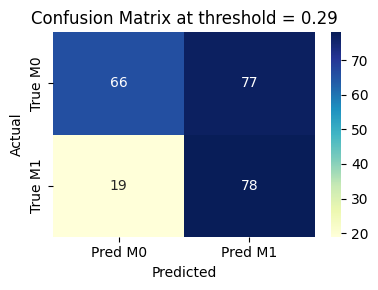

In [21]:
#threshold = 0.29일때 Confusion matrix
from sklearn.metrics import confusion_matrix

# 확률 예측값
y_score = model.predict_proba(X_test)[:, 1]

# threshold = 0.29 기준으로 이진 예측
threshold = 0.29
y_pred_thresh = (y_score >= threshold).astype(int)

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_thresh)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"])
plt.title(f"Confusion Matrix at threshold = {threshold}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


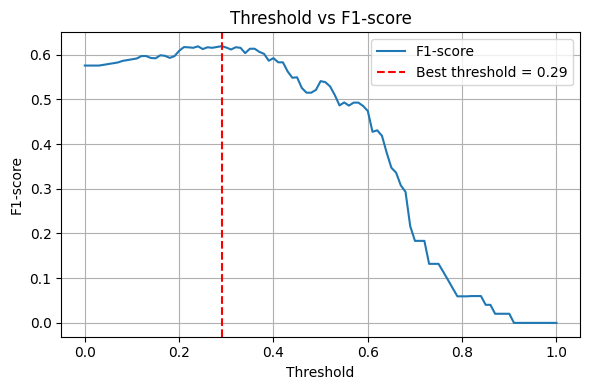

In [15]:
#threshold VS F1-score 그래프
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# threshold 후보 생성
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

# 각 threshold에 대해 F1 계산
for thresh in thresholds:
    y_pred_t = (y_score >= thresh).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_test, y_pred_t, average='binary', zero_division=0)
    f1_scores.append(f1)

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label="F1-score")
plt.axvline(0.29, color='red', linestyle='--', label="Best threshold = 0.29")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("Threshold vs F1-score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


M1 recall을 올리기 위해 SMOTE 도입 (8주차 발표 목적으로 생성)

In [23]:
!pip install imbalanced-learn

✅ SMOTE 적용 완료
Before SMOTE: M0=731, M1=509
After SMOTE : M0=731, M1=731

 Classification Report (with SMOTE):

 [Test] Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       143
           1       0.58      0.61      0.60        97

    accuracy                           0.67       240
   macro avg       0.66      0.66      0.66       240
weighted avg       0.67      0.67      0.67       240



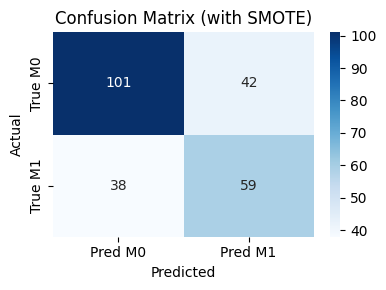

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------
# 1. SMOTE로 학습 데이터 오버샘플링
# -------------------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("✅ SMOTE 적용 완료")
print(f"Before SMOTE: M0={sum(y_train==0)}, M1={sum(y_train==1)}")
print(f"After SMOTE : M0={sum(y_resampled==0)}, M1={sum(y_resampled==1)}")

# -------------------------------------
# 2. 모델 학습
# -------------------------------------
model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
model_smote.fit(X_resampled, y_resampled)

# -------------------------------------
# 3. 예측 및 평가
# -------------------------------------
y_pred_smote = model_smote.predict(X_test)
acc = accuracy_score(y_test, y_pred_smote)


print("\n Classification Report (with SMOTE):")
print(f"\n [Test] Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred_smote, digits=2))

# Confusion Matrix 시각화
conf_mat_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"])
plt.title("Confusion Matrix (with SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

XGBoost에 대해서도 8주차 주간발표 내용 적용하기

✅ 병합된 데이터 shape: (1480, 9)
📊 TVT 분포:
 tvt
train    991
valid    249
test     240
Name: count, dtype: int64

 Classification Report (XGBoost):

 [Test] Accuracy: 0.6833
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       143
           1       0.61      0.59      0.60        97

    accuracy                           0.68       240
   macro avg       0.67      0.67      0.67       240
weighted avg       0.68      0.68      0.68       240



c:\Users\mskim\anaconda3\envs\stardist_py38\lib\site-packages\xgboost\core.py:158: UserWarning: [11:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


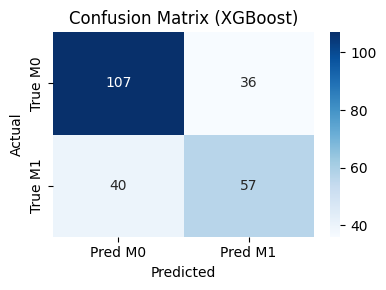

In [11]:
# ============================================
# M0/M1 분류: XGBoost 모델 전체 코드
# (TVT 기반 분할 + 평가 포함)
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -------------------------------------
# 1. 데이터 로드
# -------------------------------------
df_feat = pd.read_csv("C:/glom ML task/selected_features_with_filepath.csv")
df_tvt = pd.read_csv("C:/glom ML task/241121_updated_m0m1e1.csv")

# -------------------------------------
# 2. filepath 기준 병합
# -------------------------------------
df_tvt['filepath_clean'] = df_tvt['filepath'].apply(
    lambda x: x.replace('\\', '/').split('/')[-2] + '/' + x.split('/')[-1]
)

df_merged = pd.merge(
    df_feat,
    df_tvt[['filepath_clean', 'tvt']],
    left_on='filepath',
    right_on='filepath_clean',
    how='inner'
)

print("✅ 병합된 데이터 shape:", df_merged.shape)
print("📊 TVT 분포:\n", df_merged['tvt'].value_counts())

# -------------------------------------
# 3. 학습/테스트 분리
# -------------------------------------
trainval_df = df_merged[df_merged['tvt'].isin(['train', 'valid'])]
test_df = df_merged[df_merged['tvt'] == 'test']

X_train = trainval_df.drop(columns=["filepath", "filepath_clean", "label", "tvt"])
y_train = trainval_df["label"]

X_test = test_df.drop(columns=["filepath", "filepath_clean", "label", "tvt"])
y_test = test_df["label"]

# -------------------------------------
# 4. XGBoost 모델 학습
# -------------------------------------
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1,  # 클래스 불균형 시 조정 가능
    random_state=42
)

model.fit(X_train, y_train)

# -------------------------------------
# 5. 예측 및 평가
# -------------------------------------
y_pred = model.predict(X_test)

print("\n Classification Report (XGBoost):")
print(f"\n [Test] Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, digits=2))

# Confusion matrix 시각화
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"])
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

✅ SMOTE 적용 완료
Before SMOTE: M0=731, M1=509
After SMOTE : M0=731, M1=731

 Classification Report (with SMOTE):

 [Test] Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       143
           1       0.58      0.61      0.60        97

    accuracy                           0.67       240
   macro avg       0.66      0.66      0.66       240
weighted avg       0.67      0.67      0.67       240



c:\Users\mskim\anaconda3\envs\stardist_py38\lib\site-packages\xgboost\core.py:158: UserWarning: [14:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


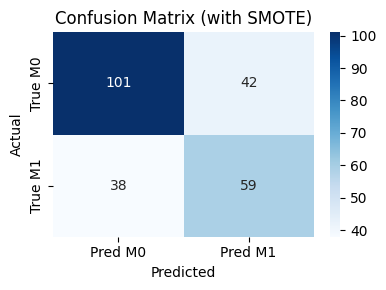

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------
# 1. SMOTE로 학습 데이터 오버샘플링
# -------------------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("✅ SMOTE 적용 완료")
print(f"Before SMOTE: M0={sum(y_train==0)}, M1={sum(y_train==1)}")
print(f"After SMOTE : M0={sum(y_resampled==0)}, M1={sum(y_resampled==1)}")

# -------------------------------------
# 2. 모델 학습
# -------------------------------------
model_xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_resampled, y_resampled)

# -------------------------------------
# 3. 예측 및 평가
# -------------------------------------
y_pred_smote = model_smote.predict(X_test)
acc = accuracy_score(y_test, y_pred_smote)


print("\n Classification Report (with SMOTE):")
print(f"\n [Test] Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred_smote, digits=2))

# Confusion Matrix 시각화
conf_mat_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_mat_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred M0", "Pred M1"],
            yticklabels=["True M0", "True M1"])
plt.title("Confusion Matrix (with SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()